# Atividade 02 - Feature Engineering

Aluno: Pedro Henrique Cardoso Paulo<br>
Disciplina: HIML<br>
Professor: Helon

## Passo 0 - Importação dos pacotes

In [1]:
import scipy.io as sio
import numpy as np
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt

## Passo 1 - Importação dos dados

Essa parte consiste basicamente no script disponibilizado pelo professor para leitura dos dados. Aqui os dados serão lidos e tratados.

In [2]:
fname = join(getcwd(),'data','data3SS2009.mat')
mat_contents = sio.loadmat(fname)

dataset = mat_contents['dataset']

N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases

y = mat_contents['labels'].reshape(Nc)

y

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5

In [3]:
Nc

850

(8192, 850)


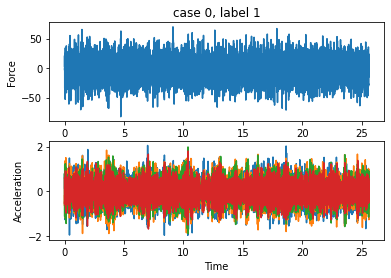

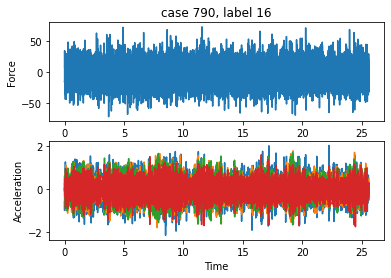

In [4]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
print(Ch1.shape)
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time = (np.linspace(1,N,N) - 1) * Ts

for case in np.array([0,790]):
    plt.figure(case)
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time,Ch1[:,case])
    plt.ylabel('Force')
    plt.subplot(212)
    plt.plot(time,Ch2[:,case],time,Ch3[:,case],time,Ch4[:,case],time,Ch5[:,case])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()

## Passo 2 - Determinando coeficientes AR

In [5]:
from statsmodels.tsa.ar_model import AutoReg

C:\Users\pedro\Anaconda3\envs\mlcourse_py3.9\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


Essa etapa consiste no exercício 4.a. Os dados serão concatenados após determinação dos coeficientes da rede AR

### 2.0 - Testando API do AutoReg

In [6]:
ar = AutoReg(Ch2[:,0],lags=30).fit()

In [7]:
ar.params

array([-0.39021604, -0.67795944, -1.69565064, -1.78157708, -2.74780861,
       -2.96025951, -4.01750495, -4.37873713, -5.33920988, -5.64324275,
       -6.34654365, -6.31779091, -6.67900269, -6.51851064, -6.68543692,
       -6.38139789, -6.1953328 , -5.54819455, -5.09847168, -4.35960086,
       -3.85561137, -3.12917123, -2.60659457, -1.98563462, -1.54403328,
       -1.03167715, -0.70305701, -0.39985584, -0.28317622, -0.14204415,
       -0.10611801])

### 2.1 - Preparando matriz de inputs

Notar que se espera que essa matriz tenha 31 x 4 = 124 colunas<br>
Para um modelo de ordem n, vc pode ter n + 1 coeficientes (contando um bias)

In [8]:
#loop feito para cada canal e cada sequência de medidas
trends = [Ch2, Ch3, Ch4, Ch5]
data_processed = []
n_lag = 30

for trend in trends:
    samples_par = []
    for case in range(Nc):
        results = AutoReg(trend[:,case],lags=n_lag).fit()
        samples_par.append(results.params)
        #print('Params shape = {}'.format(results.params.shape))
    samples_par = np.vstack(tuple(samples_par))
    print('Output shape = {}'.format(samples_par.shape))
    data_processed.append(samples_par)

data_processed = np.hstack(data_processed)       

Output shape = (850, 31)
Output shape = (850, 31)
Output shape = (850, 31)
Output shape = (850, 31)


In [9]:
data_processed.shape

(850, 124)

### 2.2 - Visualizando o modelo de dados

Para a visualização de dados 3D (matriz com valores) vou usar o recurso pcolor. Nessa visualização os valores da matriz aparecem como cores. que se referem à magnitude e sinal da grandeza

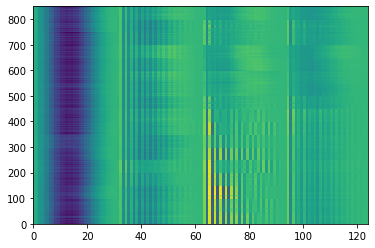

In [10]:
X1 = data_processed
plt.pcolor(data_processed)

Algumas conclusões do teste dessa visualização:
* É bem interessante que dá pra distinguir os canais claramente. Na transição entre os coeficientes do canal 2 e 3 tem uma zona bem demarcada. Isso é útil de ressaltar e ter em mente na hora de aplicarmos o PCA;
* È legal reparar que as maiores variações nas amostragens parecem associadas ao canal 4. Isso é interessante e faz certo sentido pois é a medida relativa ao andar em que temos o batente no setup experimental;

## Passo 3 - Aplicando o PCA

In [11]:
from sklearn.decomposition import PCA

In [12]:
# Valor de .99 arbitrario, mas será usado em todas as avaliações
nc_pca = 0.99
pca = PCA(n_components=nc_pca).fit(X1)

pca.explained_variance_ratio_

array([0.62176697, 0.12020622, 0.08847011, 0.08046362, 0.02772186,
       0.02049277, 0.01108656, 0.00768786, 0.00639637, 0.00533638,
       0.00269888])

### 3.1 - Visualizando os componentes principais

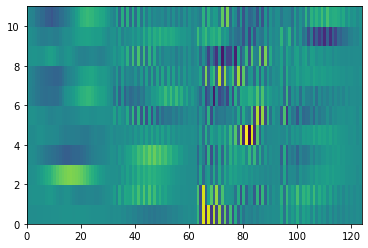

In [13]:
plt.pcolor(pca.components_)

Interessante notar que os autovetores do PCA também tem uma variação muito grande concentrada na região do canal 4, o que parece fazer sentido se considerarmos que esse canal é o que mais sofre com a variação do experimento

### 3.2 - Visualizando a transformação da matriz pelo PCA

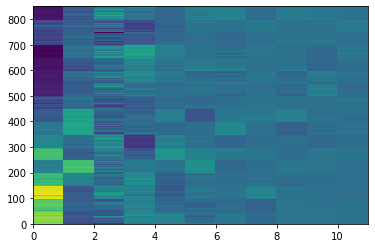

In [14]:
# Visualizando a acumulada da variância explicada
X2 = pca.transform(X1)
plt.pcolor(X2)

Aqui o que talvez seja mais interessante de notar é como a variação da grandeza de cada componente principal se torna menos relevante conforme subimos a ordem. A primeira coluna, correspondente ao PC1 tem variações muito mais expressivas que a décima, quase homogênea. Isso é importante e faz sentido se considerarmos que o primeiro componente tem 60% da variância

## Passo 4 - Testando impacto da escala

Nesta seção, vamos testar dois scalers do sklearn nos nossos dados: o MinMaxScaler que, embora normalize os valores entre 0 e 1, é análogo à normalização proposta pelo exercício, e o StandardScaler, que normaliza os valores usando a média e o desvio padrão.

In [15]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [16]:
scaler1 = MinMaxScaler().fit(X1)
scaler2 = StandardScaler().fit(X1)

X1_sc01 = scaler1.transform(X1)
X1_sc02 = scaler2.transform(X1)

### 4.1 - Visualizando impacto dos normalizadores

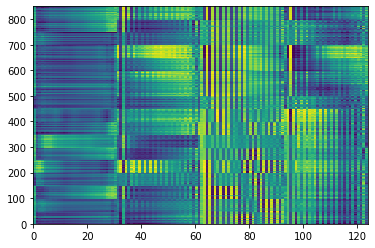

In [17]:
#Testando visualmente o scaler 01
plt.pcolor(X1_sc01)

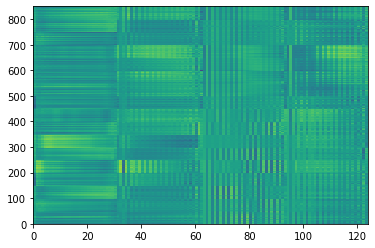

In [18]:
#Testando visualmente o scaler 02
plt.pcolor(X1_sc02)

CONCLUSÃO: O Scaler 01 (MinMax) parece fazer um trabalho melhor de ressaltar as diferenças entre os features. Vamos ver como isso afeta os resultados mais a frente

### 4.2 Rodando o PCA para as variáveis normalizadas

In [19]:
pca_sc01 = PCA(n_components=nc_pca).fit(X1_sc01)
pca_sc02 = PCA(n_components=nc_pca).fit(X1_sc02)
print(pca_sc01.explained_variance_ratio_)
print(pca_sc02.explained_variance_ratio_)



[0.38668883 0.19957401 0.09947381 0.09264925 0.04839605 0.04227173
 0.03639468 0.02073334 0.01980863 0.01098041 0.008105   0.00668096
 0.00505577 0.00362728 0.00318064 0.00232399 0.00187323 0.00174332
 0.00144638]
[0.29427901 0.22036792 0.15462446 0.08908687 0.04981727 0.04166145
 0.04073531 0.02500861 0.02226926 0.01176123 0.00949707 0.00776593
 0.00702215 0.00420626 0.00329035 0.00270268 0.00215607 0.00196869
 0.00158091 0.00128772]


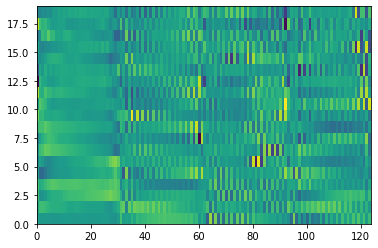

In [20]:
#Visualizando os PCs
plt.pcolor(pca_sc01.components_)

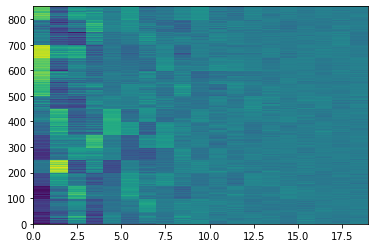

In [21]:
#Visualizando a matriz transformada
X2_sc01 = pca_sc01.transform(X1_sc01)
plt.pcolor(X2_sc01)

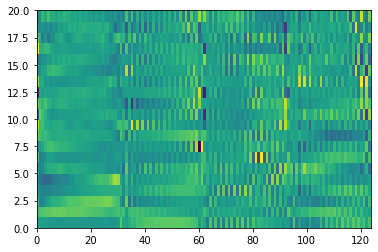

In [22]:
#Visualizando os PCs
plt.pcolor(pca_sc02.components_)

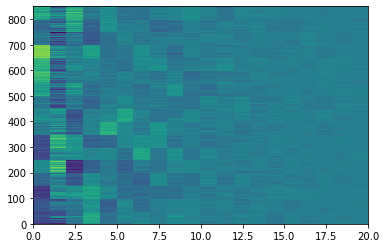

In [23]:
#Visualizando a matriz transformada
X2_sc02 = pca_sc02.transform(X1_sc02)
plt.pcolor(X2_sc02)

É interessante notar nas visualizações que há semelhanças consideráveis entre os PCs e matrizes transformadas das duas estratégias de normalização, cabendo-se fazer os seguintes comentários:

* O StandardScaler levaou a um espaço em que se precisou de mais variáveis para se descrever a mesma variância explicada
* Isso faz com qu o MinMaxScaler já tenha um vetor de primeira posição mais relevante
* Ambos precisaram de mais PCs para a mesma variância que o caso 1, o que se justifica por eles terem deixado mais aparentes as variações nas variâneis de menor magnitude, um pouco ofuscadas pelo canal 4

## Passo 5 - Ajustando preditores

Nesse passo faremos o ajuste dos preditores softmax para todos os nossos conjuntos de dados. Sumarizando:

* X1 corresponde aos dados pós AR sem tratamento
* X2 corresponde aos dados pós AR e pós PCA com 99% de variância
* X1_sc01 corresponde aos dados pós AR escalados pelo MinMaxScaler
* X2_sc01 corresponde aos dados pós AR escalados pelo MinMaxScaler e pós PCA com 99% de variância
* X1_sc02 corresponde aos dados pós AR escalados pelo StandardScaler
* X2_sc02 corresponde aos dados pós AR escalados pelo StandardScaler e pós PCA com 99% de variância

A metodologia de comparação consistirá em:

* Separar os dados em conjunto de treino e teste (com 20% para teste)
* Ajustar o LogisticRegression com multi_class "multinomial" (deve usar a função SoftMax)
* Comparar os scores do conjunto de treino e de teste
* Comparar as iterações necessárias para cada caso (medida de performance)
* Comparar o plot das matrizes de confusão de cada caso

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [25]:
# Separando treino e teste
X1_tr, X1_te, X2_tr, X2_te, X1_sc01_tr, \
X1_sc01_te, X1_sc02_tr, X1_sc02_te, X2_sc01_tr, \
X2_sc01_te, X2_sc02_tr, X2_sc02_te, y_tr, y_te = \
train_test_split(X1, X2, X1_sc01, X1_sc02, X2_sc01, X2_sc02, y, test_size=0.2, random_state=42)

### 5.1 - Usando X1

In [26]:
# Generating estimators and calculating scores
logreg = LogisticRegression(multi_class='multinomial', random_state=42, max_iter=5000).fit(X1_tr, y_tr)

score_train = logreg.score(X1_tr, y_tr)
score_test = logreg.score(X1_te, y_te)

print('Train score: {}'.format(score_train))
print('Test score: {}'.format(score_test))
print()
n = 1
for niter in logreg.n_iter_:
    print('Class {} demanded {} iterations'.format(n, niter))
    n += 1


Train score: 0.9955882352941177
Test score: 0.9941176470588236

Class 1 demanded 2420 iterations


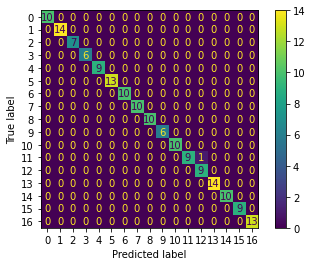

In [27]:
#Plotting confusion matrix
cm = confusion_matrix(y_te, logreg.predict(X1_te))
ConfusionMatrixDisplay(cm).plot()


### 5.2 - Usando X2

In [28]:
# Generating estimators and calculating scores
logreg = LogisticRegression(multi_class='multinomial', random_state=42, max_iter=5000).fit(X2_tr, y_tr)

score_train = logreg.score(X2_tr, y_tr)
score_test = logreg.score(X2_te, y_te)

print('Train score: {}'.format(score_train))
print('Test score: {}'.format(score_test))
print()
n = 1
for niter in logreg.n_iter_:
    print('Class {} demanded {} iterations'.format(n, niter))
    n += 1


Train score: 0.9823529411764705
Test score: 0.9882352941176471

Class 1 demanded 335 iterations


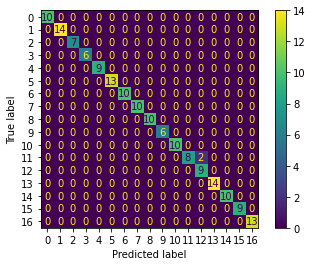

In [29]:
#Plotting confusion matrix
cm = confusion_matrix(y_te, logreg.predict(X2_te))
ConfusionMatrixDisplay(cm).plot()

### 5.3 - Usando X1_sc01

In [30]:
# Generating estimators and calculating scores
logreg = LogisticRegression(multi_class='multinomial', random_state=42, max_iter=5000).fit(X1_sc01_tr, y_tr)

score_train = logreg.score(X1_sc01_tr, y_tr)
score_test = logreg.score(X1_sc01_te, y_te)

print('Train score: {}'.format(score_train))
print('Test score: {}'.format(score_test))
print()
n = 1
for niter in logreg.n_iter_:
    print('Class {} demanded {} iterations'.format(n, niter))
    n += 1

Train score: 0.9941176470588236
Test score: 0.9941176470588236

Class 1 demanded 266 iterations


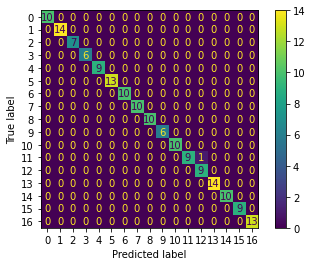

In [31]:
#Plotting confusion matrix
cm = confusion_matrix(y_te, logreg.predict(X1_sc01_te))
ConfusionMatrixDisplay(cm).plot()

### 5.4 - Usando X1_sc02

In [32]:
# Generating estimators and calculating scores
logreg = LogisticRegression(multi_class='multinomial', random_state=42, max_iter=5000).fit(X1_sc02_tr, y_tr)

score_train = logreg.score(X1_sc02_tr, y_tr)
score_test = logreg.score(X1_sc02_te, y_te)

print('Train score: {}'.format(score_train))
print('Test score: {}'.format(score_test))
print()
n = 1
for niter in logreg.n_iter_:
    print('Class {} demanded {} iterations'.format(n, niter))
    n += 1

Train score: 1.0
Test score: 1.0

Class 1 demanded 340 iterations


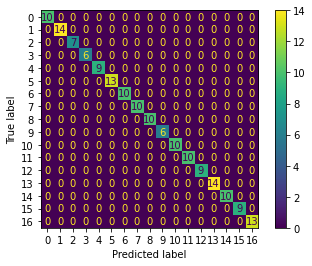

In [33]:
#Plotting confusion matrix
cm = confusion_matrix(y_te, logreg.predict(X1_sc02_te))
ConfusionMatrixDisplay(cm).plot()

### 5.5 - Usando X2_sc01

In [34]:
# Generating estimators and calculating scores
logreg = LogisticRegression(multi_class='multinomial', random_state=42, max_iter=5000).fit(X2_sc01_tr, y_tr)

score_train = logreg.score(X2_sc01_tr, y_tr)
score_test = logreg.score(X2_sc01_te, y_te)

print('Train score: {}'.format(score_train))
print('Test score: {}'.format(score_test))
print()
n = 1
for niter in logreg.n_iter_:
    print('Class {} demanded {} iterations'.format(n, niter))
    n += 1

Train score: 0.9941176470588236
Test score: 0.9941176470588236

Class 1 demanded 64 iterations


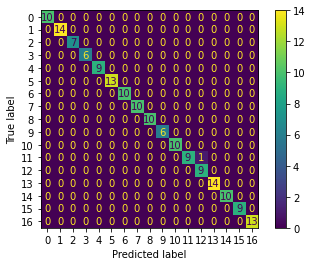

In [35]:
#Plotting confusion matrix
cm = confusion_matrix(y_te, logreg.predict(X2_sc01_te))
ConfusionMatrixDisplay(cm).plot()

### 5.6  - Usando X2_sc02

In [36]:
# Generating estimators and calculating scores
logreg = LogisticRegression(multi_class='multinomial', random_state=42, max_iter=5000).fit(X2_sc02_tr, y_tr)

score_train = logreg.score(X2_sc02_tr, y_tr)
score_test = logreg.score(X2_sc02_te, y_te)

print('Train score: {}'.format(score_train))
print('Test score: {}'.format(score_test))
print()
n = 1
for niter in logreg.n_iter_:
    print('Class {} demanded {} iterations'.format(n, niter))
    n += 1

Train score: 0.9985294117647059
Test score: 1.0

Class 1 demanded 328 iterations


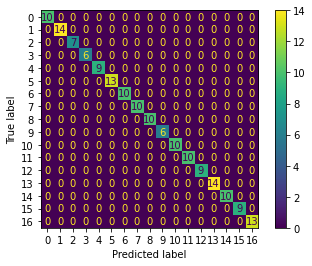

In [37]:
#Plotting confusion matrix
cm = confusion_matrix(y_te, logreg.predict(X2_sc02_te))
ConfusionMatrixDisplay(cm).plot()

## 6 - Conclusões do estudo

Algumas conclusões desse estudo específico:

* Tanto a aplicação de técnicas de redução de dimensionalidade quanto a aplicação de normalizadores melhorou consideravelmente a performence do preditor (de > 2500 iterações para < 400)
* Nesse sentido, o efeito da escala parece ser mais relevante que o efeito do número de variáveis, com o MinMaxScaler para nosso caso sendo o que retornou os menores números de iterações
* Todos os testes feitos retornaram scores acima de 98%, o que parece ser um indicativo de que, independentemente da estratégia, a predição retornaria bons resultados
* O melhor modelo imperformance foi usando X2_sc01, enquanto o melhor modelo em score foi o X1_sc02